# Probability and Likelihood

This notebook takes a very simple example of extracting some parameters from a Gaussian distributed dataset. 
These parameters are of course the mean, $\mu$, and width, $\sigma$, of that dataset.
I show here most of the common methods used:
 - HESSE error estimates from Minuit. I don't mention this much otherwise but is probably the default thing you will use. This is minuit's estimate of the error from the inverse Hessian matrix. It's what RooFit uses (because RooFit's minimisation backend is minuit)
 - Profile Likelihood (this one is also very commonly used). It's what minuit you does when you call MIGRAD
 - Feldman-Cousins. I generate toy MC to obtain confidence intervals in our two-dimensions. I then also show some of the common treatements when only wanting to quote an interval in 1D:
   - The `plugin` or `profiled` method (fix nuisance parameter values
   - The `Gaussian smearing` method (it may have a more official name but I don't know it)
   - The `Berger-Boos` method (uniform sampling)
   - There is also the `Cousins-Highland` method which I haven't bothered with here because it requires some prior knowledge of the nuisance parameter expectation
 - Bayesian. I generate some Markov Chain MC (MCMC) to obtain the posterior distribution
 
Because this is such a simple example and because it is relatively high statistics and Gaussian distributed, rather unsurprisingly all of these methods gives very similar results. You can see this from the 2D plot at the bottom. There is some variation because the Feldman-Cousins and Bayesian methods require sampling and I didn't bother sampling for very long.

If you run this notebook (and want to generate all the data yourself, rather than just read it from the files I've already made) it will take about an hour on a decent machine. You then start to realise why the profile likelihood method is so popular and why alternatives are only really needed when you expect the profile likelihood to fail. 

It's also worth noting that for most cases the Hesse error estimate from minuit is as good as the Profile likelihood anyway.

    

## Step 1. Generate some data, fit it and plot it

Notice the probability distribution, `pdf`, is defined for parameters $\mu$ and $\sigma$ and depends on the value we are measuring in our data $x$ (this could be a mass or because it peaks at 0 more like a $\Delta$ mass).

The likelihood (given by the function `n2ll` which evaluates the twice the negative logarithm of the likelihood) depends on the values of $\mu$ and $\sigma$ given the observation of our values $x$ stored in `gen_data`

We perform a fit, by minimising the $\ln L$, to get our best estimate of the parameters $\hat{\mu}$ and $\hat{
\sigma}$.

┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mean  │   0.039   │   0.031   │            │            │         │         │       │
│ 1 │ sigma │   0.981   │   0.022   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


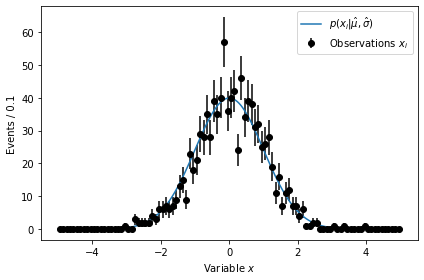

In [1]:
from scipy.stats import norm
from scipy.stats import chi2
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
import pickle

# set the seed so reproducible
np.random.seed(1)

# define a probability distribution (just a Gaussian)
# given some "true" underyling parameters, mu and sigma
mu_true = 0
sg_true = 1
pdf = norm(mu_true,sg_true)

# generate some data from it. these data are i observations of variable x
global gen_data
gen_data = pdf.rvs(size=1000)

# now define the twice the negative log likelihood for mu and sigma given
# the observations x
def n2ll(mean, sigma):
    global gen_data
    p = norm(mean,sigma)
    return -2*np.sum( p.logpdf(gen_data) )

# now find the values of mean and sigma which minimise the n2ll
mi = Minuit( n2ll, errordef=1, pedantic=False, mean=0, sigma=1 )
mi.migrad() # the minimisation
mi.hesse()  # the error matrix estimate
print(mi.params)

# and stash the result for later
global_min_vals = dict(mi.values)
global_min_errs = dict(mi.errors)
global_min_nll  = float(mi.fmin.fval)

# and let's plot the data and the fit result
prange = (-5,5)
pbins = 100
xbins = 400
bwidth = (prange[1]-prange[0])/pbins
pdfnorm = 1./np.diff(norm.cdf(prange)) * len(gen_data) * bwidth

x = np.linspace(*prange,xbins)
w, xe = np.histogram(gen_data, bins=pbins, range=prange )
xc = 0.5*(xe[1:]+xe[:-1])

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.errorbar( xc, w, yerr=w**0.5, fmt='ko', label='Observations $x_i$' )
ax.plot( x, pdfnorm*pdf.pdf(x), label='$p(x_i|\hat{\mu},\hat{\sigma})$' )
ax.legend()
ax.set_xlabel('Variable $x$')
ax.set_ylabel('Events / {0}'.format(bwidth))
fig.tight_layout()
fig.savefig('prob.pdf')

## A quick detour to remember the $\chi^2$ distribution

Recall that we are making the assumption our $-2\Delta\ln L$ is distributed like a $\chi^2$ with 1 degree of freedom. So below I have plotted the $\chisq$ distribution for 1 and 2 degrees of freedom. To find out what value of the $\chi^2$ will then contain $X\%$ of the distribution we can read off the value of the cumulative distribution function which gives $X\%$. `scipy.stats` has some very nice built in functionality to see this. The point I really want to make is the following
 - Most people remember that 1$\sigma$ contains 68.3\% and that this corresponds to $\chi^2=1$ (in 1D)
 - As we progress up in $\sigma$ then the corresponding $\chi^2$ value (in 1D) is at $\sigma^2$.
 - In other words for 1D $\chi^2=\{1,4,9\}$ contains $\{68.3\%, 95.4\%, 99.7\%\}$
 - The common confusion is when you move up to 2 degress of freedom (so when looking at profile likelihood contours in 2D)
 - In this case, i.e. for 2D, then $\chi^2=\{1,4,9\}$ only contain $\{39.3\%, 86.5\%, 98.9\%\}$
 - So if you want the contours containing $\{68.3\%, 95.4\%, 99.7\%\}$ in 2D you need to evaluate the $-2\Delta\ln L$ at $\{2.30,6.18,11.53\}$
 
The functions from `scipy.stats.chi2` which help you figure this out are `cdf()` and `ppf()`

68.27% contained in 1D up to 1.0 in 2D up to 2.3


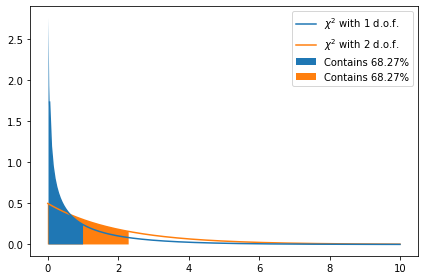

In [2]:
# some reminders of chi^2 distributions in 1D (and 2D)
from scipy.stats import chi2

x = np.linspace(0,10,200)
fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(x,chi2.pdf(x,1),label='$\chi^2$ with 1 d.o.f.',zorder=3)
ax.plot(x,chi2.pdf(x,2),label='$\chi^2$ with 2 d.o.f.',zorder=2)


# plot that values that contain 68.3% 
cl = chi2.cdf(1,1) # this gives us the 68.3% (i.e. it's one sigma with 1 dof)

x1d = np.linspace(0, chi2.ppf(cl,1), 50)
x2d = np.linspace(0, chi2.ppf(cl,2), 50)
ax.fill_between(x1d, 0, chi2.pdf(x1d,1),label='Contains {:4.2%}'.format(cl),zorder=1)
ax.fill_between(x2d, 0, chi2.pdf(x2d,2),label='Contains {:4.2%}'.format(cl),zorder=0)
ax.legend()
fig.tight_layout()
fig.savefig('chi2.pdf')

print('{:4.2%}'.format(cl),'contained in 1D up to {:3.1f}'.format(chi2.ppf(cl,1)),'in 2D up to {:3.1f}'.format(chi2.ppf(cl,2)))

## Step 2. Now we can take a look at the profile likelihood

In the above step minuit has minimised the $-2\Delta\ln L$ for us and it has used the (inverse) Hessian to estimate the uncertainty. We can also take a look at what the likelihood actually looks like by scanning it.
This is also known as "profiling" the likelihood (you are profiling because at each value you are scanning for you fix that value and then minimise with respect to any others) and is another method for obtaining errors. N Note that minuit can also do this for you if you call `mi.minos()`

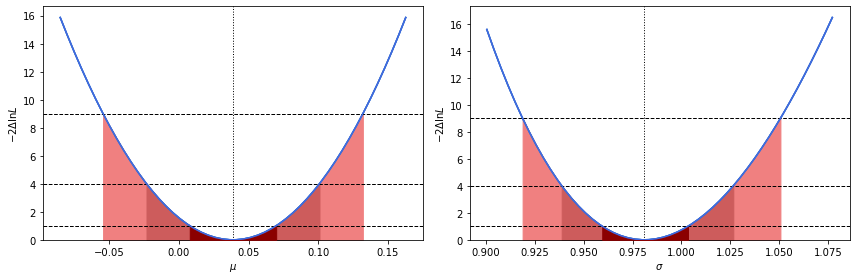

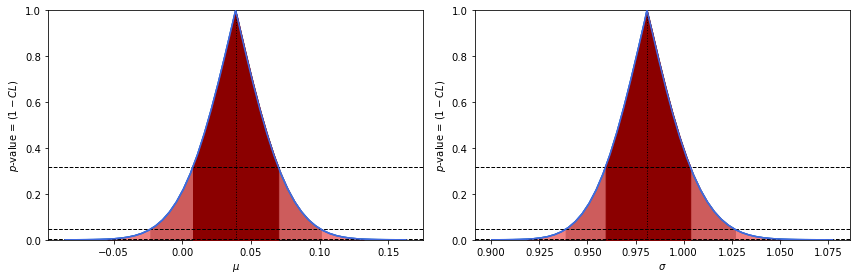

In [3]:
# make a function which will return the n2ll value at a given scan point for a variable
# when it has been minimized over all other parameters (this is what the profiling refers to)
def scan1d( var, x ):
    assert( var in mi.values.keys() )
    mi.values[var] = x
    mi.fixed[var] = True
    mi.migrad()
    nll = mi.fmin.fval
    mi.fixed[var] = False
    return nll

# make a vectorised version to simplify our lives
scan1dVec = np.vectorize( scan1d, excluded=['var'] )

# and make a little wrapper function that does this in a range
# and then shifts the whole set of values back to zero (remember we
# care about the Delta likelihood i.e. the difference from the minimum
# not the absolute value)
def runScan1d( var, range, points, back_to_zero=True ):
    
    x = np.linspace(*range, points)
    y = scan1dVec(var,x)
    
    # add the global min
    ind = np.argmin( x < global_min_vals[var] )
    x = np.insert( x, ind, global_min_vals[var] )
    y = np.insert( y, ind, global_min_nll )
    
    # push everything back to zero
    if back_to_zero:
        y -= np.min(y)
    
    return x, y  

# scan the value of the mean
murange  = ( mi.values['mean']-4*mi.errors['mean'], mi.values['mean']+4*mi.errors['mean'] )
xmu, ymu = runScan1d( 'mean', murange, 50 )

# scan the value of sigma
sgrange = ( mi.values['sigma']-4*mi.errors['sigma'], mi.values['sigma']+4*mi.errors['sigma'] )
xsg, ysg = runScan1d( 'sigma', sgrange, 50 )

# make a funtion to see where the scan values cross a particular value in y
# for -2DeltaLL which is approximately the same as DeltaChi2 then the crossing
# points for [1,2,3] sigma are [1,4,9] i.e. at nsigma**2
def find_crossing( x, y, cross, xmin ):
    
    lower = interp1d( y[x<xmin], x[x<xmin], kind='quadratic' )
    upper = interp1d( y[x>xmin], x[x>xmin], kind='quadratic' )

    return lower(cross), upper(cross)

# a function to plot the 1D profile likelihood scans
def nll1dplot( x, y, ax=None, ispval=False ):

    ax = ax or plt.gca()
    ind = np.argmax(y) if ispval else np.argmin(y)
    xmin = x[ind]
    ax.plot( x, y )
    smooth = interp1d(x,y)
    cols = ['darkred','indianred','lightcoral']
    ax.plot( x, y, color='royalblue', zorder=0 )
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    intervals = []
    for nsig in range(1,4):
        cross = 1-chi2.cdf(nsig**2,1) if ispval else nsig**2
        low, upp = find_crossing( x, y, cross, xmin )
        label = '${0}\sigma$'.format(nsig)
        xsm = np.linspace(low,upp,50)
        intervals.append( [low,upp] )
        ax.fill_between( xsm, 0, smooth(xsm), color=cols[nsig-1], lw=1, label=label, zorder=4-nsig )
        ax.plot(xlim,(cross,cross),'k--', lw=1, zorder=8-nsig)
    ax.plot( (xmin,xmin), (0,ylim[1]), 'k:', lw=1, zorder=9 )
    ax.plot( x, y, color='royalblue', zorder=10 )
    ax.set_xlim(xlim)
    ax.set_ylim(0,ylim[1])
    if ispval: ax.set_ylim(0,1)
    if ispval: ax.set_ylabel('$p$-value = $(1-CL)$')
    else: ax.set_ylabel('$-2\Delta \ln L$')
    return xmin, intervals
    #ax.legend()
    
# make the 1D scan plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
pl_mean = nll1dplot( xmu , ymu , ax[0] )
ax[0].set_xlabel('$\mu$')
pl_sigma = nll1dplot( xsg, ysg, ax[1] )
ax[1].set_xlabel('$\sigma$')
fig.tight_layout()
fig.savefig('n2ll1d.pdf')

# note you often see these converted to p-value or 1-CL plots
# so we'll make those as well
fig, ax = plt.subplots(1,2, figsize=(12,4))
nll1dplot( xmu, 1-chi2.cdf(ymu,1), ax[0], ispval=True )
nll1dplot( xsg, 1-chi2.cdf(ysg,1), ax[1], ispval=True )
ax[0].set_xlabel('$\mu$')
ax[1].set_xlabel('$\sigma$')
fig.tight_layout()
fig.savefig('pvals1d.pdf')


### Can also do a 2D scan of the likelihood

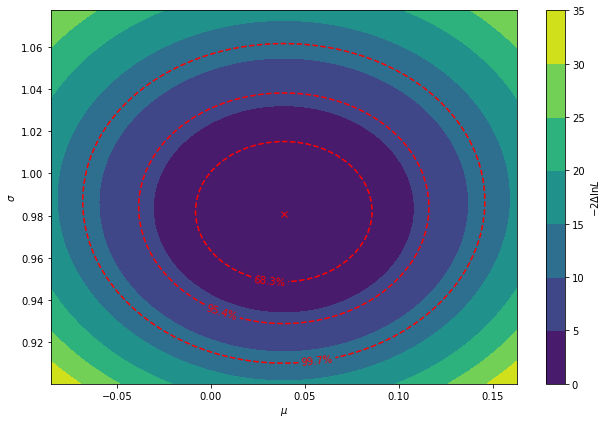

In [4]:
## 2D scan function
def scanBoth( x, y ):
    mi.values['mean'] = x
    mi.fixed['mean'] = True
    mi.values['sigma'] = y
    mi.fixed['sigma'] = True
    mi.migrad()
    nll = mi.fmin.fval
    mi.fixed['mean'] = False
    mi.fixed['sigma'] = False
    return nll

# and a vectorised version
scanBothVec = np.vectorize( scanBoth )

# wrapper function to make a nice 2D plot of the likelihood
def nll2dplot( x, y, z, ax=None, use2dcl=True, clmarkers=False, usePval=False ):

    ax = ax or plt.gca()

    im = ax.contourf( x, y, z )

    levels = [0]
    if use2dcl:
        # these are the DeltaChi2 levels corresponding to 1, 2, 3 sigma in 2D
        if usePval:
            levels = list(reversed([ 1-chi2.cdf(nsig**2,1) for nsig in range(1,4)]))
        else:
            levels += [ chi2.ppf( chi2.cdf(nsig**2,1),2) for nsig in range(1,4) ]
    else:
        if usePval:
            levels = list(reversed([ 1-chi2.cdf(nsig**2,1) for nsig in range(1,4)]))
        else:
            levels += [ nsig**2 for nsig in range(1,4) ]

    # for the contour labels
    label_markers = {}
    for i, level in enumerate(levels):
        if clmarkers:
            if use2dcl:
                label_markers[level] = '{:4.1%}'.format( chi2.cdf(i**2,1) )
            else:
                label_markers[level] = '{:4.1%}'.format( chi2.cdf(i**2,2) )
            if usePval:
                label_markers[level] = '{:4.1%}'.format( 1-level )
        else:
            if use2dcl: # going to draw something misleading otherwise
                label_markers[level] = '${0}\sigma$'.format(i)

    cs = ax.contour(x, y, z, levels=levels, colors='r', linestyles='--' )
    ax.clabel(cs, fmt=label_markers )
    cb = fig.colorbar(im, ax=ax)
    if usePval: cb.set_label('$p$-value')
    else: cb.set_label('$-2\Delta\ln L$')
    ax.plot( global_min_vals['mean'], global_min_vals['sigma'], 'rx')

Xpl, Ypl = np.meshgrid( xmu, xsg )
pl_vals = scanBothVec( Xpl, Ypl )
# get back to zero
pl_vals -= np.min(pl_vals)

fig, ax = plt.subplots(1,1,figsize=(9,6))
nll2dplot( Xpl, Ypl, pl_vals, ax, clmarkers=True )
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
fig.tight_layout()
fig.savefig('n2ll2d.pdf')



### Some other 2D plot styles

Can also make wireframe or surface plots too depending on what visualisation you prefer. Notice that in this case because the two variables are so uncorrelated there is not really much information gained from the 2D plot. The 1D plots allow us to read off an interval which is nice to quote in a paper because when we publish we like to write things like I measured $X = (x\pm y)$.

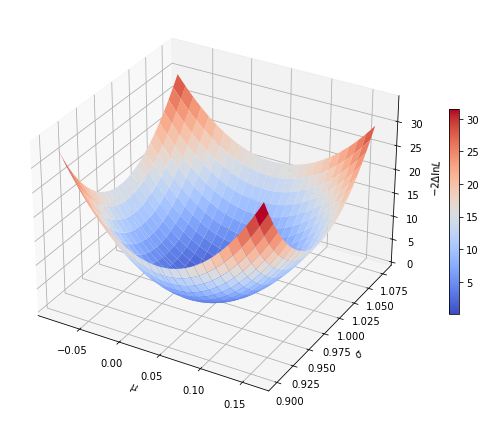

In [6]:
# if you want you can make wireframe or surface plots too
# depending on what visualisation you prefer
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
#ax.plot_wireframe( Xpl, Ypl, pl_vals )
surf = ax.plot_surface( Xpl, Ypl, pl_vals, cmap=cm.coolwarm )
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$-2\Delta\ln L$')
fig.colorbar(surf, shrink=0.5, pad=0.05)
fig.tight_layout()
fig.savefig('n2llsurf.pdf')

## Step 3. Now let's try out the Feldman-Cousins

To start with I will do this in 2D i.e. in the full dimensional space of our problem. This is the original vision of Feldman-Cousins and it also has the advantage that the result can actually be presented in a human readable way. For dimensionality higher than 2D you can compute the $p$-values but it's hard to know how you would actually present them. For that we need some kind of "projection" method which is covered in the next step.

This is pretty slow if you want to run it yourself (do so by changing the `doScans=True` flag). I have run this locally myself (takes about 20mins) and saved the result so we can load it here.

Note I need to scan points in every dimension, so for a $25\times 25$ grid this is already 625 scan points. Then at each scan point I need to throw a number of toys to estimate the $p$-value. I have chosen 250 toys per scan point but for more accurate results you would want more (500-1000 would probably be enough for a publication level result). In each of these toys I am generating a dataset which has the equivalent size to the original ($N=1000$) so to do this full FC scan I need to perform a lot of fits.

In [7]:
### now do we do the 2D FC thing

# some handy values to keep track of things
# this is useful as I've vectorised the function
# but I want to keep track of the number of calls
global neval
neval = 0
npoints = 25

# make a copy of the real data so I don't accidentally overwrite it
real_data = np.copy(gen_data)

# a wrapper function for performing the FC p-value calculation
# at a given scan point
def fcScanBoth( x, y, ntoys=250, status=False ):
    
    global neval
    global gen_data
    
    # stash the "real data"
    real_data = np.copy(gen_data)
    
    # fit to the "real data" at our scan point
    mi.values['mean'] = x
    mi.fixed['mean'] = True
    mi.values['sigma'] = y
    mi.fixed['sigma'] = True
    mi.migrad()
    nll = mi.fmin.fval
    mi.fixed['mean'] = False
    mi.fixed['sigma'] = False
    
    # figure out the DeltaLL of this scan point in data
    dnll_data = nll - global_min_nll
    
    # now generate and fit some toys equivalent to the data sample
    smpl_size = len(gen_data)
    
    nworse = 0
    for ntoy in range(ntoys):
        # generate a toy
        gen_data = norm(x,y).rvs(size=smpl_size)
        
        # fit the toy with the scan values fixed
        mi.values['mean'] = x
        mi.fixed['mean'] = True
        mi.values['sigma'] = y
        mi.fixed['sigma'] = True
        mi.migrad()
        nll_toy_fixed = mi.fmin.fval
        
        # fit the toy with all the values floating
        mi.fixed['mean'] = False
        mi.fixed['sigma'] = False
        mi.migrad()
        nll_toy_float = mi.fmin.fval
        
        # get the difference and see if it's worse (ie larger) than that for the data
        dnll_toy = nll_toy_fixed - nll_toy_float
        if dnll_toy > dnll_data:
            nworse += 1
            
        if status: print('{:4d} / {:4d} : {:4d} / {:4d}'.format(neval, npoints**2, ntoy+1, ntoys), end='\r', flush=True)
    
    # compute the p-value as the fraction of toys worse than the data
    pval = float(nworse)/ntoys
    neval += 1
    
    # put the stash of the real data back
    gen_data = np.copy(real_data)
          
    return pval

# make a vectorised version
fcScanBothVec = np.vectorize( fcScanBoth, excluded=['ntoys','status'] )

# make the grid we're going to scan over
x = np.linspace(*murange,npoints)
y = np.linspace(*sgrange,npoints)
X, Y = np.meshgrid(x,y)

doScans = False

## this scan really does take a while so we'll only do it once and save the result
## then otherwise we can just load it up nice n' quick in future
if doScans:
    
    print("This will take a while. Go make a coffee.")
    
    fc_vals = fcScanBothVec( X, Y, ntoys=250, status=True )

    # make sure we've put the gen_data back
    gen_data = np.copy(real_data)
    
    # save the result
    res2dFC = { 'X': X , 'Y': Y, 'vals': fc_vals }
    with open('data/res2dFC.pkl','wb') as f:
        pickle.dump( res2dFC, f )
        
else:
    
    # load the result
    print("Loading previously run scan to save time")
    
    with open('data/res2dFC.pkl','rb') as f:
        res2dFC = pickle.load(f)
        
    X = res2dFC['X']
    Y = res2dFC['Y']
    fc_vals = res2dFC['vals']
    
    

Loading previously run scan to save time


### Now plot the 2D Feldman-Cousins contours

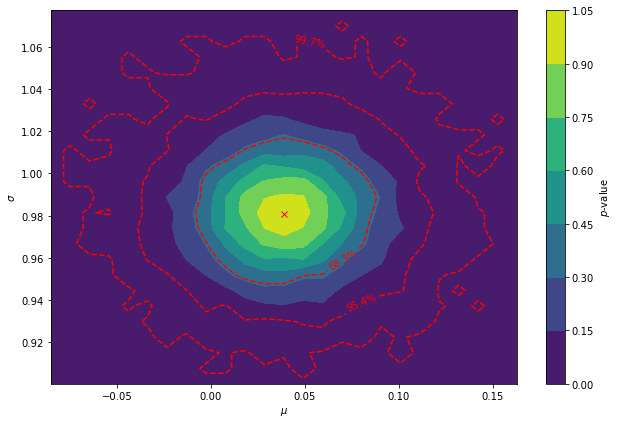

In [8]:
fig, ax = plt.subplots(1,1,figsize=(9,6))
x = np.linspace(*murange,npoints)
y = np.linspace(*sgrange,npoints)
X, Y = np.meshgrid(x,y)
nll2dplot( X, Y, fc_vals, ax, clmarkers=True, usePval=True )
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
fig.tight_layout()
fig.savefig('fc2d.pdf')



## Next we're going to have a look at 1D Feldman-Cousins scans

Ok so now I'm doing something which demonstrates what has to be done in the real-world because full Feldman-Counsins scans are computationally intensive and problematic to present.

This time we scan in 1D (note we could also do this in 2D for a higher dimensional problem). Now we have to figure out what we are going to do in our FC toys with the other parameter (the "nuisance" parameter) that we are not scanning for (eg in a scan for $\mu$ I fix the value of $\mu$ to the scan point value and generate a toy but what value of $\sigma$ do I chose when generating a toy?).

The common choice is to choose the profile likelihood value of $\sigma$, this is known as the **plugin** or **profiled** method. Another option (not used very often to my knowledge) it to take this value but smear it by the profiled likelihood error (I have called this the **Gaussian smear** method, I don't know if it has a proper name). An even more extreme version is the so-called **Berger-Boos** method in which we sample in some uniform confidence-region of the parameter, $(1-\beta)$, where you then adjust the final $(1-CL)$ or $p-value$ by adding $\beta$. Here I have chosen the interval which is $\pm 3\sigma$ from the profiled value, so $\beta = 0.0027$.

In this very simple case these all give very similar results. A few things to note are that the **plugin** method can suffer from undercoverage if a nuisance parameter is a near a physical boundary, the **Berger-Boos** method will overcover by definition.

In [9]:
### now do we do the 1D FC things

# some handy values to keep track of things
# this is useful as I've vectorised the function
# but I want to keep track of the number of calls
global neval
neval = 0
npoints = 25

# make a copy of the real data so I don't accidentally overwrite it
real_data = np.copy(gen_data)

# a wrapper function for performing the FC p-value calculation
# at a given scan point
def fcScan1d(var, x, ntoys=250, status=False, method='plugin'):
    
    assert(method in ['plugin','profiled','gauss','uniform'])
    
    global neval
    global gen_data
    # stash the "real data"
    real_data = np.copy(gen_data)
    
    # fit to the "real data"
    assert(var in mi.values.keys())
    mi.values[var] = x
    mi.fixed[var] = True
    mi.migrad()
    nll = mi.fmin.fval
    mi.fixed[var] = False
    other_par = mi.values['sigma'] if var=='mean' else mi.values['mean']
    other_err = mi.errors['sigma'] if var=='mean' else mi.errors['mean']
     
    dnll_data = nll - global_min_nll
    
    # now generate and fit some toys equivalent to the data sample
    smpl_size = len(gen_data)
    
    nworse = 0
    for ntoy in range(ntoys):
        # what do we do with the other parameter(s)?
        y = None
        if method=='plugin' or method=='profiled': # use the profiled value
            y = other_par
        elif method=='gauss': # use a Gaussian smeared value
            y = np.random.normal(other_par,other_err)
        elif method=='uniform': # use a uniform random value in +/- 3 sigma
            y = np.random.uniform(other_par-3*other_err, other_par+3*other_err)
        else:
            assert(0)
            
        # generate a toy
        toy_mean = x if var=='mean' else y
        toy_sigma = y if var=='mean' else x
        
        gen_data = norm(toy_mean,toy_sigma).rvs(size=smpl_size)
        
        # fit the toy with the scan value fixed 
        # reset starting values
        mi.values['mean'] = 0
        mi.values['sigma'] = 1
        mi.values[var] = x
        mi.fixed[var] = True
        mi.migrad()
        nll_toy_fixed = mi.fmin.fval
        
        # fit the toy with the values floating
        # reset starting values
        mi.values['mean'] = 0
        mi.values['sigma'] = 1
        mi.fixed[var] = False
        mi.migrad()
        nll_toy_float = mi.fmin.fval
        
        # get the difference see if it's worse
        dnll_toy = nll_toy_fixed - nll_toy_float
        #assert(dnll_toy>=0)
        
        if dnll_toy > dnll_data:
            nworse += 1
            
        if status: print('{:4d} / {:4d} : {:4d} / {:4d}'.format(neval, npoints*6, ntoy+1, ntoys), end='\r', flush=True)
    
    pval = float(nworse)/ntoys
    neval += 1
    
    # put the stash back
    gen_data = np.copy(real_data)       
          
    return dnll_data, pval

# make a vectorised version
fcScan1dVec = np.vectorize( fcScan1d, excluded=['var','ntoys','status','method'] )

# scan spaces
xmean  = np.linspace(*murange,npoints)
xsigma = np.linspace(*sgrange,npoints)

doScans = False

## the actual scanning takes some time so do it once and save a file
## so we can load it up nice n' quick in the future
if doScans:

    print("This will take a while. Go make a coffee")
    
    n2llm, ymean_pl = fcScan1dVec( 'mean', xmean, ntoys=250, status=True, method='plugin' )
    n2llm, ymean_gs = fcScan1dVec( 'mean', xmean, ntoys=250, status=True, method='gauss' )
    n2llm, ymean_un = fcScan1dVec( 'mean', xmean, ntoys=250, status=True, method='uniform' )

    n2lls, ysigma_pl = fcScan1dVec( 'sigma', xsigma, ntoys=250, status=True, method='plugin' )
    n2lls, ysigma_gs = fcScan1dVec( 'sigma', xsigma, ntoys=250, status=True, method='gauss' )
    n2lls, ysigma_un = fcScan1dVec( 'sigma', xsigma, ntoys=250, status=True, method='uniform' )

    # make sure we've put the gen_data back
    gen_data = np.copy(real_data)

    ## save the scan results
    res1dFCmean = { 'x'   : xmean,
                    'n2ll': n2llm,
                    'y_pl': ymean_pl,
                    'y_gs': ymean_gs,
                    'y_un': ymean_un
                  }
    
    with open('data/res1dFCmean.pkl','wb') as f:
        pickle.dump( res1dFCmean, f )
    
    res1dFCsigma = { 'x'   : xsigma,
                     'n2ll': n2lls,
                     'y_pl': ysigma_pl,
                     'y_gs': ysigma_gs,
                     'y_un': ysigma_un
                   }
    
    with open('data/res1dFCsigma.pkl','wb') as f:
        pickle.dump( res1dFCsigma, f )
        
else:
    
    print("Loading previously run scans to save time")
    
    with open('data/res1dFCmean.pkl','rb') as f:
        res1dFCmean = pickle.load(f)
    
    xmean    = res1dFCmean['x']
    n2llm    = res1dFCmean['n2ll']
    ymean_pl = res1dFCmean['y_pl']
    ymean_gs = res1dFCmean['y_gs']
    ymean_un = res1dFCmean['y_un']
    
    with open('data/res1dFCsigma.pkl','rb') as f:
        res1dFCsigma = pickle.load(f)
    
    xsigma    = res1dFCsigma['x']
    n2lls     = res1dFCsigma['n2ll']
    ysigma_pl = res1dFCsigma['y_pl']
    ysigma_gs = res1dFCsigma['y_gs']
    ysigma_un = res1dFCsigma['y_un']

Loading previously run scans to save time


### Now make some plots of the 1D FC scans

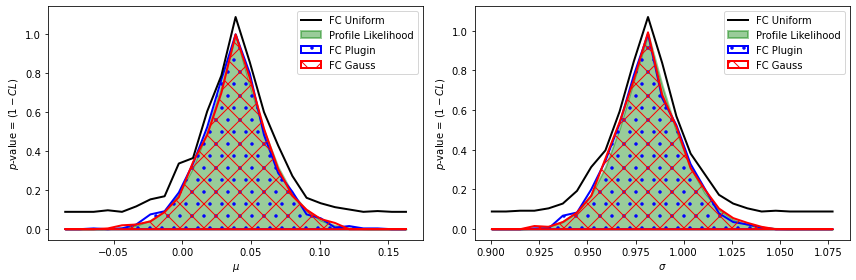

In [14]:
# first don't forget to shift the Berger-Boos (uniform) scans by the amount we sample over
# we used 3 sigma so should shift by 1-0.9973
ymean_un += 1-chi2.cdf(9,1)
ysigma_un += 1-chi2.cdf(9,1)

# make the 1D FC scan plots
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].fill_between(xmean,0,1-chi2.cdf(n2llm,1),label='Profile Likelihood', facecolor='g', edgecolor='g', alpha=0.4, lw=2, zorder=0)
ax[0].fill_between(xmean,0,ymean_pl, label='FC Plugin',hatch='.', lw=2, edgecolor='b', facecolor='none', zorder=1)
ax[0].fill_between(xmean,ymean_gs, label='FC Gauss', hatch='x', lw=2, edgecolor='r', facecolor='none', zorder=2)
ax[0].plot(xmean,ymean_un, label='FC Uniform', c='k', lw=2, zorder=3)
ax[0].set_xlabel('$\mu$')
ax[0].set_ylabel('$p$-value = $(1-CL)$')
ax[0].legend()

ax[1].fill_between(xsigma,0,1-chi2.cdf(n2lls,1),label='Profile Likelihood', facecolor='g', edgecolor='g', alpha=0.4, lw=2, zorder=0)
ax[1].fill_between(xsigma,0,ysigma_pl, label='FC Plugin',hatch='.', lw=2, edgecolor='b', facecolor='none', zorder=1)
ax[1].fill_between(xsigma,ysigma_gs, label='FC Gauss', hatch='x', lw=2, edgecolor='r', facecolor='none', zorder=2)
ax[1].plot(xsigma,ysigma_un, label='FC Uniform', c='k', lw=2, zorder=3)
ax[1].set_xlabel('$\sigma$')
ax[1].set_ylabel('$p$-value = $(1-CL)$')
ax[1].legend()

fig.tight_layout()
fig.savefig('fc1d.pdf')



## Step 4. Let's do the Bayesian equivalent

So now we can use our likelihood to build the Bayesian posterior, assuming some priors for our parameters. Here I have chosen flat priors to demonstrate the equivalency of this method with the profile likelihood and FC methods above. In reality most Bayesians prefer to use normal or ln_normal priors but it does depend of course what your prior belief is. In the high-stats limit the choice of prior should have a relatively small effect on the outcome of the posterior.

\begin{equation}
 p(\theta|x) = \frac{p(x|\theta)p(\theta)}{p(x)}
\end{equation}

Building the posterior is not so difficult but we then end up in a problem, a bit like the one we had for the full Feldman-Cousins, which is that we have a posterior probability distribution (note it's usually not normalised because computing the denominator of Bayes law, sometimes called the marginal likelihood, is a real pain) that is multi-dimensional. In order to project this down into one dimension we have to "marginalise" or "integrate" out the nuisance paramter dimensions. Even in our simple example here this is hard and for most real-life problems is just impossible.

The solutions is to use Markov Chain Monte Carlo (MCMC) to sample from the posterior distribution. My implementation below is rather rough and ready but it will do for this simple example. There are some much more sophisticated packages for Bayesian analysis like [`pymc3`](https://docs.pymc.io) which I recommend checking out if you want to implement some Bayesian inference for your analysis.  

### First I'll build then plot the posterior

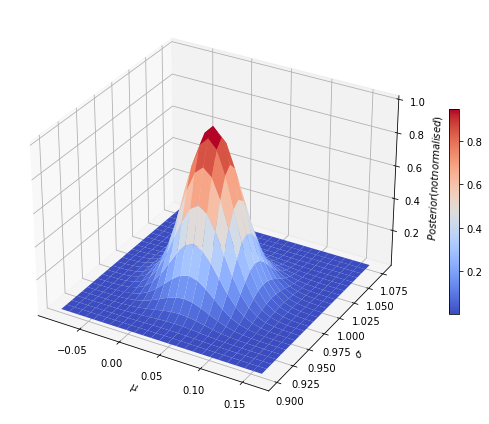

In [15]:
# the bayesian equivalent
from scipy.stats import uniform

# my bayesian likelihood is the product of the pdf
# in practise it's much easier to evalue the sum of the log
# and then shift it back to zero and then take the exponential
# of that (avoids having to multiply extremely small or large numbers)

def ln_posterior(mean, sigma):
    ll = -0.5*n2ll(mean,sigma)
    # add uniform priors for mean [-0.5,0.5] and sigma [0.5,1.5]
    ll += uniform(-0.5,1).logpdf(mean)
    ll += uniform(0.5,1).logpdf(sigma)
    return ll

vec_ln_posterior = np.vectorize(ln_posterior)

vals = vec_ln_posterior(X,Y)
# shift back to zero
vals -= np.max(vals)
# now take exponent to get probability distribution
vals = np.exp(vals)
 
fig = plt.figure(figsize=(9,6))
ax = fig.gca(projection='3d')
#ax.plot_wireframe( X, Y, vals )
surf = ax.plot_surface( X, Y, vals, cmap=cm.coolwarm )
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
ax.set_zlabel('$Posterior (not normalised)$')
fig.colorbar(surf, shrink=0.5, pad=0.05)
fig.tight_layout()
fig.savefig('posterior.pdf')

### Then I'll sample from the posterior using MCMC

Notice how this is a slightly different output to what you get from FC. In the FC case you pick a scan point and get returned a $p$-value, indeed it's the same with the profile likelihood. So for each scan value you have one return value. In the Bayesian case we are really sampling the posterior probability distribution so we end up with a sample of values in the number of dimensions our posterior has (in this case two: $\mu$ and $\sigma$). So what we get return is not something we can plot directly but rather histogram. You can see later that when I draw this I make use of a KDE to "smooth" the distribution.

The sampling in this case is quite fast (helped by the simplicity of the problem and the fact I have a pretty good idea what widths to start the sampling from) but I have, as before with the FC, already run it so this notebook will by default load the saved sample. To re-run it yourself you'll need to change the flag `runSample=True`

In [16]:
## wrapper function to sample from the posterior using MCMC
def mcmc_sample(size=10000):
    
    print('Running Bayesian MCMC')
    sample = []
    
    # sensible starting points
    mu_current = 0
    sg_current = 1

    while len(sample) < size:
        # suggest new position
        # getting this width right is very important (fortunately we can guess it quite well 
        # from our initial fit result)
        mu_proposal = norm(mu_current, global_min_errs['mean']).rvs()
        sg_proposal = norm(sg_current, global_min_errs['sigma']).rvs()
    
        # compute posterior
        ln_p_current  = ln_posterior(mu_current , sg_current) 
        ln_p_proposal = ln_posterior(mu_proposal, sg_proposal) 
    
        # accept proposal?
        ln_p_accept = ln_p_proposal - ln_p_current
    
        accept = np.random.rand() < np.exp(ln_p_accept)

        if accept:
            mu_current = mu_proposal
            sg_current = sg_proposal

        # add to the sample
        sample.append( [mu_current, sg_current] )
        if len(sample)%100==0: print(len(sample),'/',size, end='\r', flush=True)

    sample = np.array(sample)
    return sample

runSample=False

## once again we'll only run this once (although it's quite quick for the 2D case)
## so we can load it quickly in future
if runSample:
    sample = mcmc_sample(10000)
    
    with open('data/bayes_sample.pkl','wb') as f:
        pickle.dump(sample,f)
        
else:
    
    with open('data/bayes_sample.pkl','rb') as f:
        sample = pickle.load(f)
    

### Now I can plot my sampled distribution
1D first

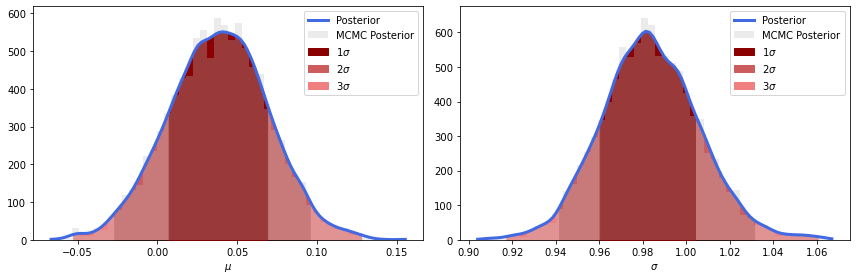

In [17]:
from scipy.stats import gaussian_kde
import arviz as az # this package has some useful function for Bayesian inference

# wrapper to make a 1D plot of the posterior from sampled values
def bayes1dplot(vals, ax=None):
    ax = ax or plt.gca()
    kernel = gaussian_kde(vals)
    bins = 50
    w, xe = np.histogram(vals,bins=bins)
    bwidth = (xe[-1]-xe[0])/bins
    x = np.linspace(xe[0],xe[-1],100)
    
    mean = np.mean(vals)
    cols = ['darkred','indianred','lightcoral']
    ax.hist(vals,bins=bins,range=(xe[0],xe[-1]),color='0.75',alpha=0.3,zorder=4, label='MCMC Posterior')
    intervals = []
    for nsig in range(1,4):
        interval = az.hdi(vals, chi2.cdf(nsig**2,1))
        xsm = np.linspace(*interval,50)
        ax.fill_between( xsm, 0, len(vals)*bwidth*kernel(xsm), color=cols[nsig-1], lw=1, zorder=4-nsig, label='${0}\sigma$'.format(nsig))
        intervals.append(interval)
    
    ax.plot(x,len(vals)*bwidth*kernel(x), color='royalblue',lw=3, zorder=5, label='Posterior')
    ax.legend()
    return mean, intervals

fig, ax = plt.subplots(1,2,figsize=(12,4))
bayes_mean = bayes1dplot(sample[:,0],ax[0])
ax[0].set_xlabel('$\mu$')
bayes_sigma = sg_int = bayes1dplot(sample[:,1],ax[1])
ax[1].set_xlabel('$\sigma$')

# can overlay the actual "true" posterior if we want to do given we know what the values should be
# we don't have this luxury in real life of course
#m = np.linspace(-0.02,0.04,50)
#y = [ ln_posterior(mi, 1) for mi in m ]
#y -= np.max(y)
#y = np.exp(y)
#ax[0].plot(m,600*y,color='r',zorder=6)

#s = np.linspace(0.98,1.02,50)
#y = [ ln_posterior(0, si) for si in s ]
#y -= np.max(y)
#y = np.exp(y)
#ax[1].plot(s,y)

fig.tight_layout()
fig.savefig('posterior1d.pdf')

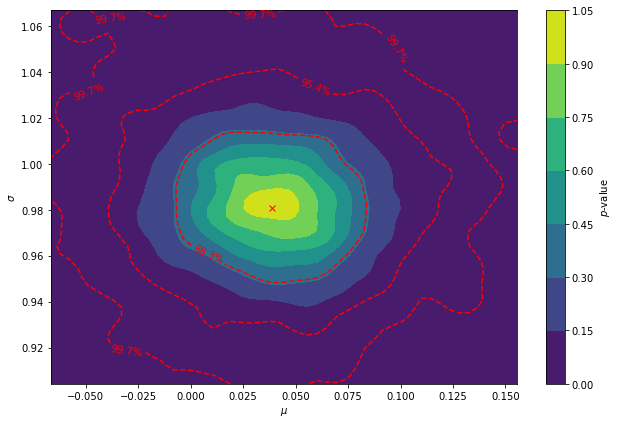

In [18]:
## Now the 2D Bayesian distribution

# get the x, y values
x = sample[:,0]
y = sample[:,1]

kde = gaussian_kde(np.vstack([x,y]))

xx, yy = np.mgrid[x.min():x.max():50j, y.min():y.max():50j]

z = np.reshape( kde(np.vstack([xx.ravel(),yy.ravel()])).T, xx.shape)
# normalise back to 1
z = (z-z.min())/(z.max()-z.min())

fig, ax = plt.subplots(1,1,figsize=(9,6))
nll2dplot( xx, yy, z, ax, clmarkers=True, usePval=True )
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
fig.tight_layout()
fig.savefig('posterior2d.pdf')

## Step 5. Let's take a look at some comparisons between the methods

You can see that in the 2D case (this is the one that relies least on the "projection" method) that all three methods (Profile Likelihood, Bayes and Feldman-Cousins) give very similar results. If I could generate infinite MC samples these would be identical. 

So what was the point in all of this? Well as mentioned there are many cases where the profile-likelihood breaks down (near boundaries, non-Gaussianity, small samples and bascially anywhere where the $\chi^2$ assumption fails). In this case you have to use one of the other options and these will give different (and more accurate results).

I also make a comparison of the 1D intervals obtained with the different methods which are largely in agreement but once again are not identical. This is both due to the method of "projection" and to the finite sample sizes of the toy MC I have generated. It does make you wonder whether there should be more discussion of uncertainties on the uncertainties.... perhaps that's for another time.

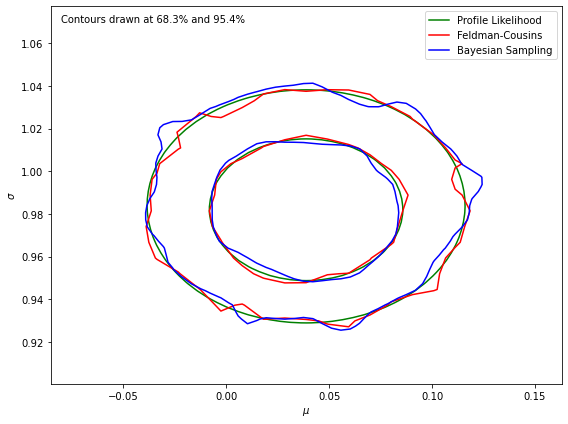

In [19]:
# 2D plot overlaying the three methods 
fig, ax = plt.subplots(1,1,figsize=(8,6))
levels = [1-chi2.cdf(4,1), 1-chi2.cdf(1,1)]
levels_pl = [ chi2.ppf(chi2.cdf(1,1),2), chi2.ppf(chi2.cdf(4,1),2)]
ax.contour(Xpl,Ypl,pl_vals,levels=levels_pl, colors='g')
ax.contour(X,Y,fc_vals,levels=levels, colors='r')
ax.contour(xx,yy,z,levels=levels,colors='b')
ax.set_xlabel('$\mu$')
ax.set_ylabel('$\sigma$')
# make a legend
from matplotlib.lines import Line2D
ax.legend( [ Line2D( [0],[0], c='g' ), Line2D( [0],[0], c='r' ), Line2D( [0],[0], c='b' ) ],
           ['Profile Likelihood','Feldman-Cousins','Bayesian Sampling'] )
ax.text( -0.08, 1.07, 'Contours drawn at {:4.1%} and {:4.1%}'.format(1-levels[1],1-levels[0]))
fig.tight_layout()
fig.savefig('compare2d.pdf')

In [20]:
# print the results
# note how a Bayesian doesn't really have a best fit value as such (can use the mean or mode or median of the posterior)
# However the width of the intervals (confidence interval for Frequentist and credible interval for Bayesian)
# is very similar

rows = []
for nsig in range(1,4):
    #rows.append( ['{:4.2%}'.format(chi2.cdf(nsig**2,1)), pl_mean[0], pl_mean[1][nsig-1][0], pl_mean[1][nsig-1][1], bayes_mean[0], bayes_mean[1][nsig-1][0], bayes_mean[1][nsig-1][1] ])
    rows.append( ['{:4.2%}'.format(chi2.cdf(nsig**2,1)), pl_mean[0], pl_mean[1][nsig-1][1]-pl_mean[1][nsig-1][0], bayes_mean[0], bayes_mean[1][nsig-1][1] - bayes_mean[1][nsig-1][0] ])

from tabulate import tabulate
#print(tabulate(rows,headers=['CL', 'PL Min', 'Interval-','Interval+','Bayes Mean','Interval-','Interval+']))
print(tabulate(rows,headers=['CL', 'PL Min', 'Interval','Bayes Mean','Interval']))

CL         PL Min    Interval    Bayes Mean    Interval
------  ---------  ----------  ------------  ----------
68.27%  0.0388125   0.0620598     0.0383486   0.0617813
95.45%  0.0388125   0.124212      0.0383486   0.122612
99.73%  0.0388125   0.186552      0.0383486   0.180635


That was a lot longer than I thought it would be! I do hope someone reads it. Any comments to matthew.kenzie@cern.ch